# Bayesian Inference II: Fitting a Straight Line

_Phil Marshall, Daniel Foreman-Mackey and Dustin Lang_

_Astro Hack Week, New York, September 2015_

This is **AstroHackWeek/inference/straightline.ipynb**

### Goals:

* Set up and carry out a simple Bayesian inference, characterizing a simple posterior PDF


* Compare brute force, analytic and MCMC sampled results


* Check models, with posterior predictive distributions of test statistics


* Use the Bayesian Evidence to compare various models, and understand its properties


* Suggest some simple hacks to get some practice with Bayesian inference

In [3]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.rcParams['savefig.dpi'] = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from straightline_utils import *

## The Data

* Let's generate a simple dataset: observations of $y$ with reported uncertainties $\sigma_y$, at given $x$ values.


* Yours will look different to mine, as your random seed will be different. That's good - we can do some (completely unrealistic) comparisons over datasets.

Requirement already up-to-date: daft in /Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages
Requirement already up-to-date: matplotlib in /Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages (from daft)
Requirement already up-to-date: numpy in /Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages (from daft)
Requirement already up-to-date: six>=1.4 in /Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages (from matplotlib->daft)
Requirement already up-to-date: python-dateutil in /Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages (from matplotlib->daft)
Requirement already up-to-date: pytz in /Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages (from matplotlib->daft)
Requirement already up-to-date: pyparsing>=1.5.6 in /Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages (from matplotlib->daft)
Requir

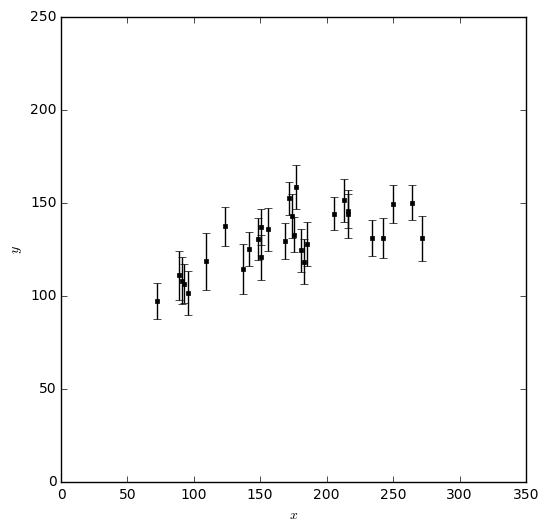

In [6]:
!pip install --upgrade daft

(x,y,sigmay) = generate_data()

plot_yerr(x, y, sigmay)

## Least-squares Straight Line Fit

* An industry standard: find the slope and intercept of a straight line that minimizes the mean square residual. Since the predicted data depend linearly on the parameters, the least squares solution can be found by a matrix inversion and multiplication, conveneniently packed in `numpy.linalg`.


* Suppose that the $y$ values are related to the $x$ values by $y = m x + b$, where $x$ and $y$ are "vectors" (`numpy` arrays). We might say that we want to find $m$ and $b$ that minimize

$W^2 = \sum_k \frac{(y_k - m x_k - b)^2}{\sigma_k^2}$


* Here, $1/\sigma_k^2$ is a sensible weighting factor that reduces the influence of $y_k$ values with large uncertainty $\sigma_k$


* Differentiating $W^2$ with respect to $m$ and $b$ and setting the result to zero leads to a matrix equation that can be solved - this is what `np.linalg.lstsq` is doing.

Weighted least-squares estimated b,m: 95.7315369935 0.206860575057


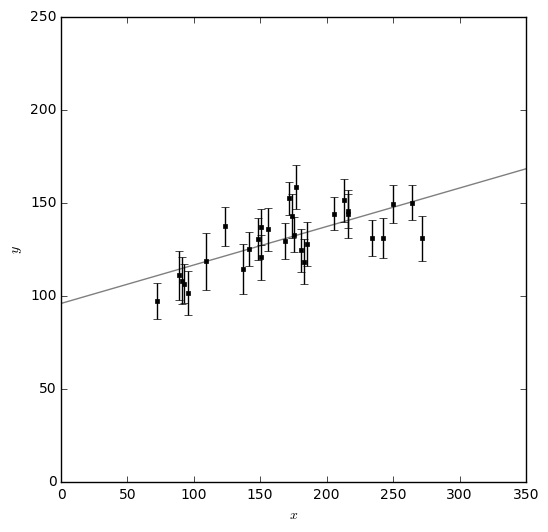

In [9]:
# Linear algebra to implement weighted least squares.
N = len(x)
A = np.zeros((N,2))
A[:,0] = 1. / sigmay
A[:,1] =  x / sigmay
yy = y / sigmay

theta,nil,nil,nil = np.linalg.lstsq(A,yy)

b_ls,m_ls = theta
print('Weighted least-squares estimated b,m:', b_ls,m_ls)

plot_yerr(x, y, sigmay)
plot_line(m_ls, b_ls);

# Probabilistic Fitting

* The Bayesian answer to the question "What are the values of $b$ and $m$ in a straight line model for the above data?" is the posterior PDF for those parameters, ${\rm Pr}(m,b|y)$


* The posterior PDF doesn't tell us the *best-fit parameter combination* - it gives us the means to simulate *all plausible parameter combinations, given the data.*


* Let's derive this posterior PDF, starting with a *probabilistic graphical model*.

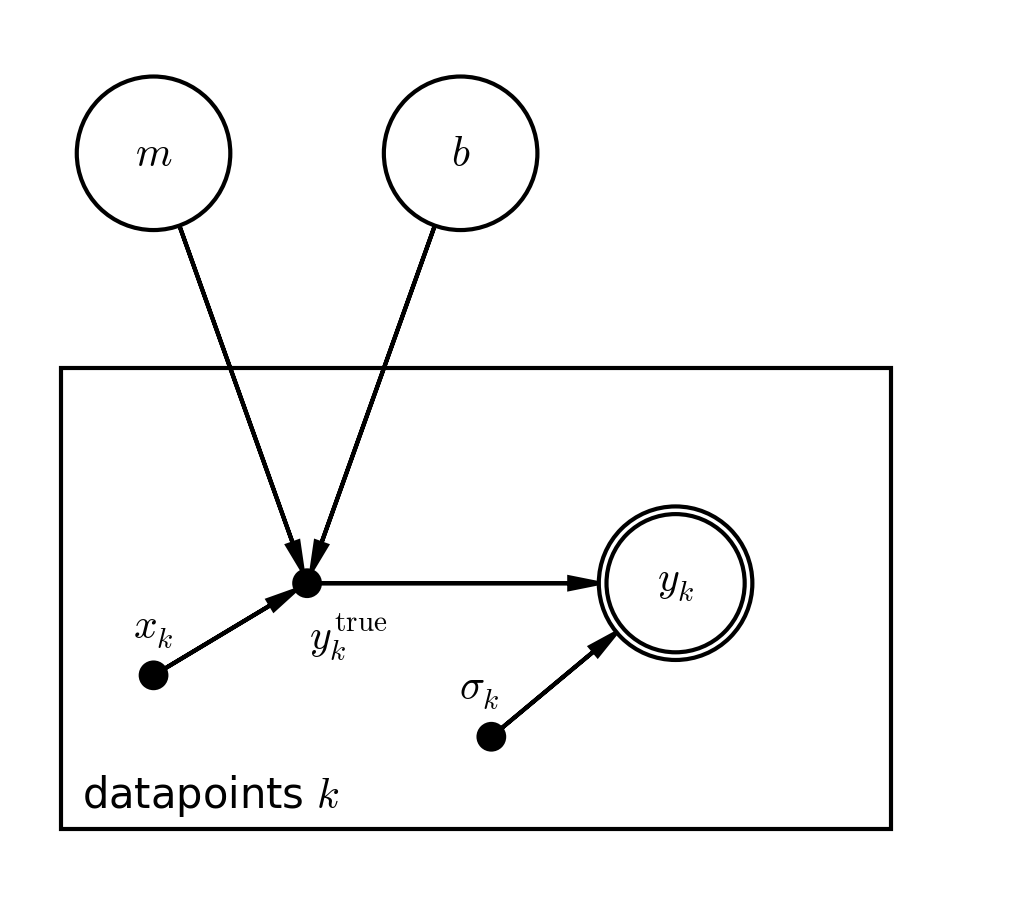

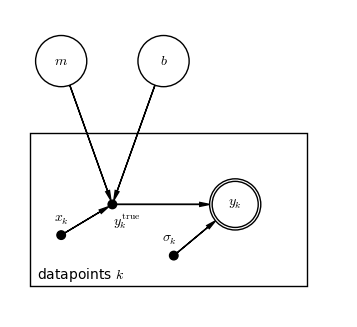

In [18]:
# import straightline_pgm
# straightline_pgm.draw();

from IPython.display import Image
Image(filename="straightline_pgm.png",width=600)

* The PGM illustrates the *forward* problem of simulating a dataset $\{y_k\}$ by drawing random numbers from *conditional* probability distributions, which are depicted by the *nodes*. The conditional dependences are depicted by the *edges*.


* The PGM is a complete description of the forward problem: it is a representation of the *joint PDF for all our variables*, ${\rm Pr}(m,b,\{y_k\},\{y^{\rm true}_k\}\,|\,\{x_k\},\{\sigma_k\})$, factorized such that we can simulate data:

${\rm Pr}(m,b,\{y_k\},\{y^{\rm true}_k\}\,|\,\{x_k\},\{\sigma_k\},H_1) 
   = \prod_k {\rm Pr}(y_k\,|\,y^{\rm true}_k,\sigma_k,H_1)
            \;{\rm Pr}(y^{\rm true}_k\,|\,x_k,m,b,H_1)
         \;\;\;{\rm Pr}(m,b\,|\,H_1)$

### Questions:

1. Where did that product come from? What assumption does it encode?

2. Why are the $\{x_k\}$ and the $\{\sigma_k\}$ always on the right hand side of the bar, but $\{y_k\}$ is sometimes on the left?

3. What is the meaning of "$H_1$"? *Hint: notice that it too is always on the right hand side of the bar.*

4. What functional form does the conditional PDF ${\rm Pr}(y^{\rm true}_k\,|\,x_k,m,b,H_1)$ have? 

5. What functional form do you think we should assume for the sampling distribution, ${\rm Pr}(y_k\,|\,y^{\rm true}_k,x_k,\sigma_k,H_1)$? *Hint: imagine you were generating mock data.*

6. What functional form should we assume for ${\rm Pr}(m,b\,|\,H_1)$?


Talk to your neighbor(s) for 5 minutes about these, note down some brief answers, and be prepared to provide them when called upon.

### The Inverse Problem

* Let's simplify our joint probability expression a bit, by marginalizing out the latent variables 
$\{y^{\rm true}_k\}$, and absorbing the $\{x_k\}$ and $\{\sigma_k\}$ into $H_1$.

${\rm Pr}(m,b,\{y_k\}|H_1) = \int\,
      \prod_k {\rm Pr}(y_k\,|\,y^{\rm true}_k,\sigma_k,H_1)
            \;{\rm Pr}(y^{\rm true}_k\,|\,x_k,m,b,H_1)
         \;\;\;{\rm Pr}(m,b\,|\,H_1) \; d y^{\rm true}_k $

$\longrightarrow {\rm Pr}(m,b,\{y_k\}|H_1) =  
      \prod_k {\rm Pr}(y_k\,|\,(m x_k + b),\sigma_k,H_1)
         \;\;\;{\rm Pr}(m,b\,|\,H_1) $
 

* Now we just factorize the left hand side and rearrange (like Bayes did), to get:

${\rm Pr}(m,b|\{y_k\},H_1) = \frac{1}{Z} \prod_k 
 {\rm Pr}(y_k\,|\,(m x_k + b),H_1)
   \;\;\;{\rm Pr}(m,b\,|\,H_1) $

* Here, $Z = {\rm Pr}(\{y_k\}\,|\,H_1)$, and is known as the "evidence" for $H_1$. It also goes by the name "Fully Marginalized Likelihood" because

$Z = {\rm Pr}(\{y_k\}\,|\,H_1) = \int \prod_k 
 {\rm Pr}(y_k\,|\,(m x_k + b),\sigma_k,H_1)
   \;{\rm Pr}(m,b\,|\,H_1)\;dm\,db$
   
and $\prod_k {\rm Pr}(y_k\,|\,(m x_k + b),\sigma_k,H_1)$ is the *joint likelihood* for the parameters. ${\rm Pr}(m,b\,|\,H_1)$ is the *prior PDF for the parameters*.

## Evaluating the posterior PDF on a grid

* For simple, 2-dimensional parameter spaces like this one, evaluating on a grid is not a bad way to go. We'll see that the least squares solution lies at the peak of the posterior PDF - for a certain set of assumptions about the data and the model.


* To compute the evidence $Z$ and normalize the posterior PDF, we need to be able to integrate the likelihood function over the prior - on a grid, we can do this numerically, to normlize the posterior PDF.


* Un-normalized, the likelihood function can take very small values, so we usually work with the log likelihood instead.

### Exercise:

With your neighbors, upgrade my log likelihood function below so that it runs faster, and you get a plot of the posterior PDF for $m$ and $b$ without having to wait.

In [10]:
def straight_line_log_likelihood(x, y, sigmay, m, b):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are
    *y_t = m * x + b*

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept

    Returns: scalar log likelihood
    '''

    L = 1.0
    for k in range(len(y)):
        L *= np.exp(-(y[k] - m*x[k] - b)**2/(2.0*sigmay[k]**2)) 
        L /= np.sqrt(2.0 * np.pi * sigmay[k]**2)
    
    return np.log(L)

In [11]:
# %load straightline_log_likelihood.py
def straight_line_log_likelihood(x, y, sigmay, m, b):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are
    *y_t = m * x + b*

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept

    Returns: scalar log likelihood
    '''

    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * sigmay))) +
            np.sum(-0.5 * (y - (m*x + b))**2 / sigmay**2))


In [12]:
def straight_line_log_prior(m, b, mlimits, blimits):
    # Uniform in m:
    if (m < mlimits[0]) | (m > mlimits[1]):
        log_m_prior = -np.inf
    else:
        log_m_prior = np.log(1.0/(mlimits[1] - mlimits[0]))
    # Uniform in b:
    if (b < blimits[0]) | (b > blimits[1]):
        log_b_prior = -np.inf
    else:
        log_b_prior = np.log(1.0/(blimits[1] - blimits[0]))
        
    return log_m_prior + log_b_prior


def straight_line_log_posterior(x,y,sigmay,m,b,mlimits,blimits):
    return (straight_line_log_likelihood(x,y,sigmay,m,b) +
            straight_line_log_prior(m,b,mlimits,blimits))

Grid maximum posterior values (m,b) = 0.22 94.0


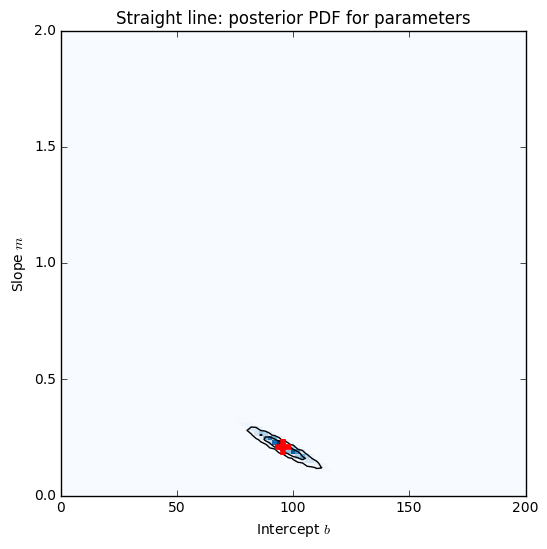

In [14]:
# Evaluate log P(m,b | x,y,sigmay) on a grid.

# Define uniform prior limits, enforcing positivity in both parameters:
mlimits = [0.0, 2.0]
blimits = [0.0, 200.0]

# Set up grid:
mgrid = np.linspace(mlimits[0], mlimits[1], 101)
bgrid = np.linspace(blimits[0], blimits[1], 101)
log_posterior = np.zeros((len(mgrid),len(bgrid)))

# Evaluate log posterior PDF:
for im,m in enumerate(mgrid):
    for ib,b in enumerate(bgrid):
        log_posterior[im,ib] = straight_line_log_posterior(x, y, sigmay, m, b, mlimits, blimits)

        
# Convert to probability density and plot, taking care with very small values:

posterior = np.exp(log_posterior - log_posterior.max())

plt.imshow(posterior, extent=[blimits[0],blimits[1],mlimits[0],mlimits[1]],cmap='Blues',
           interpolation='none', origin='lower', aspect=(blimits[1]-blimits[0])/(mlimits[1]-mlimits[0]),
           vmin=0, vmax=1)
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')

i = np.argmax(posterior)
i,j = np.unravel_index(i, posterior.shape)
print('Grid maximum posterior values (m,b) =', mgrid[i], bgrid[j])

plt.title('Straight line: posterior PDF for parameters');
plt.plot(b_ls, m_ls, 'r+', ms=12, mew=4);
plot_mb_setup(mlimits,blimits);

-----


# MCMC Sampling

* In problems with higher dimensional parameter spaces, we need a more efficient way of approximating the posterior PDF - both when characterizing it in the first place, and then when doing integrals over that PDF (to get the marginalized PDFs for the parameters, or to compress them in to single numbers with uncertainties that can be easily reported). 


* In most applications it's sufficient to approximate a PDF with a (relatively) small number of samples drawn from it; MCMC is a procedure for drawing samples from PDFs. 


* The following piece of code implements the *Metropolis algorithm*, whose derivation can be read in many textbooks. You can read a brief justification aimed at Phil's grad student self in [Chapter 2 of Phil's thesis](http://www.slac.stanford.edu/~pjm/Site/CV_files/Marshall_PhDthesis.pdf), for example.

In [ ]:
# Initial m, b, at center of prior:
m = 0.5*(mlimits[0]+mlimits[1])
b = 0.5*(blimits[0]+blimits[1])

# Step sizes, 5% or 10% of the prior
mstep = 0.05*(mlimits[1]-mlimits[0])
bstep = 0.1*(blimits[1]-blimits[0])
        
# How many steps?
nsteps = 10000
   
# We'll want to store the Markov chain as it evolves, since these are the samples we will
# use in our inferences.
chain = []
probs = []
naccept = 0
    
print('Running Metropolis Sampler for', nsteps, 'steps...')

# First point:
L_old    = straight_line_log_likelihood(x, y, sigmay, m, b)
p_old    = straight_line_log_prior(m, b, mlimits, blimits)
logprob_old = L_old + p_old

for i in range(nsteps):

    # Propose a step to a new point in parameter space:
    mnew = m + np.random.normal() * mstep
    bnew = b + np.random.normal() * bstep

    # Evaluate probabilities at the proposed point:
    L_new    = straight_line_log_likelihood(x, y, sigmay, mnew, bnew)
    p_new    = straight_line_log_prior(mnew, bnew, mlimits, blimits)
    logprob_new = L_new + p_new

    # Metropolis-Hastings acceptance criterion:
    if (np.exp(logprob_new - logprob_old) > np.random.uniform()):
        # Accept the proposed sample:
        m = mnew
        b = bnew
        L_old = L_new
        p_old = p_new
        logprob_old = logprob_new
        naccept += 1
    else:
        # Reject the proposed sample; m,b stay the same, and we append them
        # to the chain below.
        pass

    chain.append((b,m))
    probs.append((L_old,p_old))

# All steps taken, report:    
    
print('Acceptance fraction:', naccept/float(nsteps))

In [ ]:
# Pull m and b arrays out of the Markov chain and plot them:
mm = [m for b,m in chain]
bb = [b for b,m in chain]

# Traces, for convergence inspection:
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(mm, 'k-')
plt.ylim(mlimits)
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'k-')
plt.ylabel('Intercept b')
plt.ylim(blimits)

* This looks pretty good: no plateauing, or drift.


* A more rigorous test for convergence is due to Gelman & Rubin, and involves comparing the intrachain variance with the inter-chain variance in an ensemble. It's worth reading up on. 


* Foreman-Mackey & Hogg recommend looking at the autocorrelation length, and whether it stablizes during the run.


* Note that we kept all the samples, and did not discard any at the beginning of the run as "burn-in". Nor did we thin the chain at all. Both of these are good ideas.

* Now let's look at the samples in parameter space, overlaid on our gridded posterior.

In [ ]:
# First show contours from gridding calculation:
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')
plt.gca().set_aspect((blimits[1]-blimits[0])/(mlimits[1]-mlimits[0]))

# Scatterplot of m,b posterior samples, overlaid:
plt.plot(bb, mm, 'b.', alpha=0.01)
plot_mb_setup(mlimits,blimits)

### Multi-dimensional Visualization

* For a better view of a set of posterior samples, let's make a `corner` plot that shows *all 1D and 2D marginalized distributions*.

In [ ]:
!pip install --upgrade --no-deps corner

In [ ]:
import corner
corner.corner(chain, labels=['b','m'], range=[blimits,mlimits],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], 
                color='b', bins=80, smooth=1.0);

### Exercise:

Now that you have seen the Metropolis sampler in action, let's try and break it. 

With your neighbor(s), see if you can change the control parameters (ie. not the priors) to make the sampler fail in various ways - and be ready to report back in 5 minutes.

## Anyway:

With a well-tuned sampler:


* It looks like we made a nice, precise measurement! 


* Our next step is to check our model for accuracy.


-----


# Model Checking

* How do we know if our model is any good? There are two properties that "good" models have: the first is accuracy, and the second is efficiency. We'll return to th equestion of efficiency below.


* Accurate models generate data that is *like* the observed data. What does this mean? First we have to define what similarity is, in this context. Visual impression is one very important way, that's usually best done first.


* Test statistics that capture relevant features of the data are another. We'll look at the posterior predictive distributions for the datapoints, and for a particularly interesting test statistic, the reduced chi-squared.

## Visual Model Checking

* Plot posterior predictions, in data space.

In [ ]:
# Generate a straight line model for each parameter combination, and plot:
X = np.linspace(xlimits[0],xlimits[1],50)
for i in (np.random.rand(100)*len(chain)).astype(int):
    b,m = chain[i]
    plt.plot(X, b+X*m, 'b-', alpha=0.1)
plot_line(m_ls, b_ls)

# Overlay the data, for comparison:
plot_yerr(x, y, sigmay);

## Posterior Predictive Model Checking

* If our model is the true one, then *replica* data generated by it should look like the one dataset we have. This means that *summaries* of both the real dataset, $T(d)$, and the replica datasets, $T(d^{\rm rep})$, should be drawn from the same distribution. 


* If the real dataset was not generated with our model, then its summary may be an outlier from the distribution of summaries of replica datasets.


* We can account for our uncertainty in the parameters $\theta$ by marginalizing them out, which can be easily done by just making the histogram of $T(d^{\rm rep}(\theta))$ from our posterior samples, after drawing one replica dataset $d^{\rm rep}$ from the model sampling distribution ${\rm Pr}(d^{\rm rep}\,|\,\theta)$ for each one.


* Then, we can ask: what is the posterior probability for the summary $T$ to be greater than the observed summary $T(d)$? If this is very small or very large, we should be suspicious of our model - because it is not predicting the data very accurately.

${\rm Pr}(T(d^{\rm rep})>T(d)\,|\,d) = \int I(T(d^{\rm rep})>T(d))\,{\rm Pr}(d^{\rm rep}\,|\,\theta)\,{\rm Pr}(\theta\,|\,d)\;d\theta\,dd^{\rm rep}$

* Here $I$ is the "indicator function" - 1 or 0 according to the condition. 

In [ ]:
# Test statistics: functions of the data, not the parameters.

# 1) Reduced chisq for the best fit model:
def test_statistic(x,y,sigmay,b_ls,m_ls):
  return np.sum((y - m_ls*x - b_ls)**2.0/sigmay**2.0)/(len(y)-2)

# 2) Reduced chisq for the best fit m=0 model:
# def test_statistic(x,y,sigmay,dummy1,dummy2):
#    return np.sum((y - np.mean(y))**2.0/sigmay**2.0)/(len(y)-1)

# 3) Weighted mean y:
# def test_statistic(x,y,sigmay,dummy1,dummy2):
#    return np.sum(y/sigmay**2.0)/np.sum(1.0/sigmay**2.0)

# 4) Variance of y:
# def test_statistic(x,y,sigmay,dummy1,dummy2):
#    return np.var(y)


# Approximate the posterior predictive distribution for T, 
# by drawing a replica dataset for each sample (m,b) and computing its T:
T = np.zeros(len(chain))
for k,(b,m) in enumerate(chain):
    yrep = b + m*x + np.random.randn(len(x)) * sigmay
    T[k] = test_statistic(x,yrep,sigmay,b_ls,m_ls)
    
# Compare with the test statistic of the data, on a plot:   
Td = test_statistic(x,y, sigmay, b_ls, m_ls)

plt.hist(T, 100, histtype='step', color='blue', lw=2, range=(0.0,np.percentile(T,99.0)))
plt.axvline(Td, color='black', linestyle='--', lw=2)
plt.xlabel('Test statistic')
plt.ylabel('Posterior predictive distribution')


# What is Pr(T>T(d)|d)?

greater = (T > Td)
P = 100*len(T[greater])/(1.0*len(T))
print("Pr(T>T(d)|d) = ",P,"%")

* If our model is true (and we're just uncertain about its parameters, given the data), we can compute the probability of getting a $T$ less than that observed, where T is the reduced chisq relative to a straight line with some reference $(m,b)$.


* Note that we did not have to look up the "chi squared distribution" - we can simply compute the posterior predictive distribution given our generative model.


* Still, this test statistic looks a little bit strange: it's computed relative to the best fit straight line - which is a sensible reference but somehow not really in the spirit of fitting the data...

* Instead, lets look at a *discrepancy measure* $T(d,\theta)$ that is a function of both the data and the parameters, and compute the posterior probability of getting $T(d^{\rm rep},\theta) > T(d,\theta)$:

${\rm Pr}(T(d^{\rm rep},\theta)>T(d,\theta)\,|\,d) = \int I(T(d^{\rm rep},\theta)>T(d,\theta))\,{\rm Pr}(d^{\rm rep}\,|\,\theta)\,{\rm Pr}(\theta\,|\,d)\;d\theta\,dd^{\rm rep}$

In [ ]:
# Discrepancy: functions of the data AND parameters.

# 1) Reduced chisq for the model:
def test_statistic(x,y,sigmay,b,m):
   return np.sum((y - m*x - b)**2.0/sigmay**2.0)/(len(y)-2)

# Approximate the posterior predictive distribution for T, 
# by drawing a replica dataset for each sample (m,b) and computing its T, 
# AND ALSO its Td (which now depends on the parameters, too):
T = np.zeros(len(chain))
Td = np.zeros(len(chain))
for k,(b,m) in enumerate(chain):
    yrep = b + m*x + np.random.randn(len(x)) * sigmay
    T[k] = test_statistic(x,yrep,sigmay,b,m)
    Td[k] = test_statistic(x,y,sigmay,b,m)
    
# Compare T with Td, on a scatter plot - how often is T>Td?   

plt.scatter(Td, T, color='blue',alpha=0.1)
plt.plot([0.0, 100.0], [0.0, 100.], color='k', linestyle='--', linewidth=2)
plt.xlabel('Observed discrepancy $T(d,\\theta)$')
plt.ylabel('Replicated discrepancy $T(d^{\\rm rep},\\theta)$')
plt.ylim([0.0,np.percentile(Td,99.0)])
plt.xlim([0.0,np.percentile(Td,99.0)])


In [ ]:
# Histogram of differences:

diff = T-Td
plt.hist(diff, 100, histtype='step', color='blue', lw=2, range=(np.percentile(diff,1.0),np.percentile(diff,99.0)))
plt.axvline(0.0, color='black', linestyle='--', lw=2)
plt.xlabel('Difference $T(d^{\\rm rep},\\theta) - T(d,\\theta)$')
plt.ylabel('Posterior predictive distribution')


# What is Pr(T>T(d)|d)?

greater = (T > Td)
Pline = 100*len(T[greater])/(1.0*len(T))
print("Pr(T>T(d)|d) = ",Pline,"%")

* The conclusion drawn from the discrepancy is more interesting, in this case. All our $\theta = (m,b)$ samples are plausible, so replica datasets generated by them should also be plausible. The straight line defined by each $(m,b)$ should go through the real data points as readily (*on average*) as it does its replica dataset.


* Do our posterior predictive $p-$values suggest we need to improve our model? What about the visual check?


* The reduced chi-squared is actually not such an interesting test statistic - because we already used it in the likelihood! Better discrepancy measures would stress-test *different* aspects of the model - such as the correlations between datapoints, or the behavior of the model in particular places, etc. 

# Model Expansion


* Maybe I see some curvature in the data - or maybe I have a new astrophysical idea for how this data was generated. Let's try adding an extra parameter to the model, to make a quadratic function: 

$y = m x + b + q x^2$


* The coefficient $q$ is probably pretty small (we were originally expecting to only have to use a straight line model for these data!), so I guess we can assign a fairly narrow prior, centered on zero.

In [ ]:
def quadratic_log_likelihood(x, y, sigmay, m, b, q):
    '''
    Returns the log-likelihood of drawing data values y at
    known values x given Gaussian measurement noise with standard
    deviation with known sigmay, where the "true" y values are
    y_t = m*x + b + q**2

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept
    q: quadratic term coefficient

    Returns: scalar log likelihood
    '''
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * sigmay))) +
            np.sum(-0.5 * (y - (m*x + b + q*x**2))**2 / sigmay**2))
    
    
def quadratic_log_prior(m, b, q, mlimits, blimits, qpars):
    # m and b:
    log_mb_prior = straight_line_log_prior(m, b, mlimits, blimits)
    # q:
    log_q_prior = np.log(1./(np.sqrt(2.*np.pi) * qpars[1])) - \
                  0.5 * (q - qpars[0])**2 / qpars[1]**2
    return log_mb_prior + log_q_prior
    
    
def quadratic_log_posterior(x,y,sigmay,m,b,q):
    return (quadratic_log_likelihood(x,y,sigmay,m,b,q) +
            quadratic_log_prior(m,b,q))

In [ ]:
# Assign Gaussian prior for q:
qpars = [0.0,0.003]

# Initial m, b, q, at center of prior:
m = 0.5*(mlimits[0]+mlimits[1])
b = 0.5*(blimits[0]+blimits[1])
q = qpars[0]

# Step sizes
mstep, bstep, qstep = 0.05, 5.0, 0.0003
        
# How many steps?
nsteps = 10000
    
qchain = []
qprobs = []
naccept = 0
    
print('Running Metropolis sampler for', nsteps, 'steps')

# First point:
L_old    = quadratic_log_likelihood(x, y, sigmay, m, b, q)
p_old    = quadratic_log_prior(m, b, q, mlimits, blimits, qpars)
logprob_old = L_old + p_old

for i in range(nsteps):
    # step
    mnew = m + np.random.normal() * mstep
    bnew = b + np.random.normal() * bstep
    qnew = q + np.random.normal() * qstep

    # evaluate probabilities
    L_new    = quadratic_log_likelihood(x, y, sigmay, mnew, bnew, qnew)
    p_new    = quadratic_log_prior(mnew, bnew, qnew, mlimits, blimits, qpars)
    logprob_new = L_new + p_new

    if (np.exp(logprob_new - logprob_old) > np.random.uniform()):
        # Accept the new sample:
        m = mnew
        b = bnew
        q = qnew
        L_old = L_new
        p_old = p_new
        logprob_old = logprob_new
        naccept += 1
    else:
        # Reject, keep the old sample:
        pass

    qchain.append((b,m,q))
    qprobs.append((L_old,p_old))
    
print('Acceptance fraction:', naccept/float(nsteps))

In [ ]:
# Pull m, b and q arrays out of the Markov chain and plot them:
mm = [m for b,m,q in qchain]
bb = [b for b,m,q in qchain]
qq = [q for b,m,q in qchain]

# Traces, for convergence inspection:
plt.figure(figsize=(8,5))
plt.subplot(3,1,1)
plt.plot(mm, 'k-')
plt.ylim(mlimits)
plt.ylabel('m')
plt.subplot(3,1,2)
plt.plot(bb, 'k-')
plt.ylim(blimits)
plt.ylabel('Intercept b')
plt.subplot(3,1,3)
plt.plot(qq, 'k-')
plt.ylim([qpars[0]-3*qpars[1],qpars[0]+3*qpars[1]])
plt.ylabel('Quadratic coefficient q')

In [ ]:
corner.corner(qchain, labels=['b','m','q'], range=[blimits,mlimits,(qpars[0]-3*qpars[1],qpars[0]+3*qpars[1])],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], 
                color='green', bins=80, smooth=1.0);

* All parameters are again precisely constrained.


* The gradient and intercept $m$ and $b$ are significantly different from before, though...

## Checking the Quadratic Model

In [ ]:
# Posterior visual check, in data space:
X = np.linspace(xlimits[0],xlimits[1],100)
for i in (np.random.rand(100)*len(chain)).astype(int):
    b,m,q = qchain[i]
    plt.plot(X, b + X*m + q*X**2, 'g-', alpha=0.1)
plot_line(m_ls, b_ls);
plot_yerr(x, y, sigmay)

In [ ]:
# Discrepancy: functions of the data AND parameters.

# 1) Reduced chisq for the model:
def test_statistic(x,y,sigmay,b,m,q):
   return np.sum((y - m*x - b - q*x**2)**2.0/sigmay**2.0)/(len(y)-3)

# 2) Some other discrepancy measure:


# Approximate the posterior predictive distribution for T, 
# by drawing a replica dataset for each sample (m,b) and computing its T, 
# AND ALSO its Td:
T = np.zeros(len(qchain))
Td = np.zeros(len(qchain))
for k,(b,m,q) in enumerate(qchain):
    yp = b + m*x + q*x**2 + sigmay*np.random.randn(len(x))
    T[k] = test_statistic(x,yp,sigmay,b,m,q)
    Td[k] = test_statistic(x,y,sigmay,b,m,q)

# Histogram of differences:
diff = T - Td
plt.hist(diff, 100, histtype='step', color='green', lw=2, range=(np.percentile(diff,1.0),np.percentile(diff,99.0)))
plt.axvline(0.0, color='black', linestyle='--', lw=2)
plt.xlabel('Difference $T(d^{\\rm rep},\\theta) - T(d,\\theta)$')
plt.ylabel('Posterior predictive distribution')

# What is Pr(T>T(d)|d)?
greater = (T > Td)
Pquad = 100*len(T[greater])/(1.0*len(T))
print("Pr(T>T(d)|d,quadratic) = ",Pquad,"%, cf. Pr(T>T(d)|d,straightline) = ",Pline,"%")

* How do the two models compare? Which one matches the data better?

All of the above discussion was about *model checking* - assessment of the ability of a model to make accurate predictions. 


* We used *replicated data*, drawn from the model assuming it was true, and then looked at the probability of getting (a summary of) the data, given this assumption.


* Note the parallel with frequentist hypothesis testing:

**Frequentist:** assume the null hypothesis $H_0$, and calculate the probability of getting the estimators for the parameters by chance, by studying the distribution of a test statistic over a large ensemble of replica datasets (which under certain assumptions is a standard distribution).

**Bayesian:** assume the alternative hypothesis $H_1$, and calculate the posterior predictive probability distribution for the test statistic given the data, relative to the one test statistic we observed, marginalizing over the model parameters. In general this distribution will be non-standard, but we can often draw samples from the posterior PDF anyway.


* The Bayesian posterior predictive check is fairly conservative, by comparison with tests that focus on the best-fit parameters. This can be a good thing, to err on the side of caution. 

### Hack Suggestion: Bayesian Cross Validation with SciKit-Learn

* An interesting alternative to posterior predictive model checking is to follow the machine learning approach, and use cross-validation to assess model prediction accuracy.


* What should the algorithm be? Here's a starter suggestion:
```
   split data into training set dt and holdback test set dh
      infer Pr(x|dt), drawing posterior samples in x
      predict dhp
      compute score, using dhp and dh  
   combine scores   
```
* What should the "score" be? `Pr(dh|dt)`, marginalizing over x? Machine learning "Accuracy"? How should we combine the scores?


* `scikit-learn` already has a nice API, with (I guess) a `Model` class and some very useful cross-validation machinery. Maybe we could write `BayesianModel` that inherits from `Model`, and give it a sampler, priors, etc, as well as `fit` and `predict` methods (which could return *ensembles of samples* instead of point estimates).

-----

# Model Comparison with the Bayesian Evidence

* The evidence for model $H$, ${\rm Pr}(d\,|\,H)$, enables a form of Bayesian hypothesis testing via the evidence ratio (or "odds ratio", or "Bayes Factor"):

$R = \frac{{\rm Pr}(d\,|\,H_1)}{{\rm Pr}(d\,|\,H_0)}$


* This quantity is similar to a likelihood ratio, but it's a *fully marginalized likelihood ratio* - which is to say that it *takes into account our uncertainty about values of the parameters of each model by integrating over them all.*


* As well predictive accuracy, the other virtue a model can have is *efficiency*. The evidence summarizes *all* the information we put into our model inferences, via both the data *and* our prior beliefs.  You can see this by inspection of the integrand of the fully marginalized likelihood (#FML) integral:

${\rm Pr}(d\,|\,H) = \int\;{\rm Pr}(d\,|\,\theta,H)\;{\rm Pr}(\theta\,|\,H)\;d\theta$


* The consequence of this is that the Evidence depends on *both* model accuracy (goodness of fit, ability to predict data) *and* efficiency (not over-fitting by having implausible flexibility). 

* The following figure might help illustrate how the evidence depends on both goodness of fit (through the likelihood) and the complexity of the model (via the prior). In this 1D case, a Gaussian likelihood (red) is integrated over a uniform prior (blue): the evidence can be shown to be given by $E = f \times L_{\rm max}$, where $L_{\rm max}$ is the maximum possible likelihood, and $f$ is the fraction of the blue dashed area that is shaded red. $f$ is 0.31, 0.98, and 0.07 in each case.

In [ ]:
from IPython.display import Image
Image('evidence.png')

The illustration above shows us a few things:

1) The evidence can be made arbitrarily small by increasing the prior volume: the evidence is more conservative than focusing on the goodness of fit ($L_{\rm max}$) alone.  Of course if you assign a prior you don't believe, then you should not expect to get out a meaningful answer for ${\rm Pr}(d\,|\,H)$.

2) The evidence is linearly sensitive to prior volume ($f$), but exponentially sensitive to goodness of fit ($L_{\rm max}$). It's still a likelihood, after all.

* The odds ratio can, in principle, be combined with the ratio of priors for each model to give us the relative probability for each model being true, given the data:

$\frac{{\rm Pr}(H_1|d)}{{\rm Pr}(H_0|d)} = \frac{{\rm Pr}(d|H_1)}{{\rm Pr}(d|H_0)} \; \frac{{\rm Pr}(H_1)}{{\rm Pr}(H_0)}$


* Prior probabilities are very difficult to assign in most practical problems (notice that no theorist ever provides them). So, one way to interpret the evidence ratio is to note that:

  * If you think that having seen the data, the two models are *still equally probable,*
  * then the evidence ratio in favor of $H_1$ is you the odds that you would have had to have been willing to take against $H_1$, before seeing the data.
  * That is: the evidence ratio updates the prior ratio into a posterior one - as usual.
  

## Calculating the Evidence

* The FML is in general quite difficult to calculate, since it involves averaging the likelihood over the prior. MCMC gives us samples from the posterior - and these cannot, it turns out, be reprocessed so as to estimate the evidence stably.


* A number of sampling algorithms have been developed that *do* calculate the evidence, during the process of sampling. These include:

  * Nested Sampling (including MultiNest and DNest)
  * Parallel Tempering, Thermodynamic Integration
  * ...


* If we draw samples from the *prior*, we can then estimate the evidence via the usual sum over samples,

${\rm Pr}(d\,|\,H) \approx \sum_k\;{\rm Pr}(d\,|\,\theta,H)$
  

* Sampling the prior and computing the likelihood at each sample position is called "Simple Monte Carlo", and while it works in certain low-dimensional situations, in general it is very inefficient (at best). 


* Still, let's give it a try on our two models, and attempt to compute the Bayes Factor 
  
$R = \frac{{\rm Pr}(d\,|\,{\rm quadratic})}{{\rm Pr}(d\,|\,{\rm straight line})}$

In [ ]:
# Draw a large number of prior samples and calculate the log likelihood for each one:
N = 50000

# Set the priors:
mlimits = [0.0, 2.0]
blimits = [0.0, 200.0]
qpars = [0.0,0.003]

# Sample from the prior:
mm = np.random.uniform(mlimits[0],mlimits[1], size=N)
bb = np.random.uniform(blimits[0],blimits[1], size=N)
qq = qpars[0] + qpars[1]*np.random.randn(N)

# We'll store the posterior samples as a "chain" again
schain = []

log_likelihood_straight_line = np.zeros(N)
log_likelihood_quadratic = np.zeros(N)
for i in range(N):
    log_likelihood_straight_line[i] = straight_line_log_likelihood(x, y, sigmay, mm[i], bb[i])
    log_likelihood_quadratic[i] = quadratic_log_likelihood(x, y, sigmay, mm[i], bb[i], qq[i])    

    schain.append((bb[i],mm[i],qq[i]))
    
# Let's also compute some unnormalized likelihoods as well, to enable 
# posterior inferences via weighted sums over the samples:

likelihood_straight_line = np.exp(log_likelihood_straight_line - log_likelihood_straight_line.max())
likelihood_quadratic = np.exp(log_likelihood_quadratic - log_likelihood_quadratic.max())

Now that we have the likelihood for each sample, let's check that we did actually sample the posterior well. Here are the corner plots (note the weights, and the need to *not* plot the points as well as the contours!):

In [ ]:
corner.corner(schain, labels=['b','m','q'], range=[blimits,mlimits,(qpars[0]-3*qpars[1],qpars[0]+3*qpars[1])],quantiles=[0.16,0.5,0.84],
                weights=likelihood_straight_line,
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95], 
                color='blue', bins=80, smooth=1.0);

### Question:

* Why does $q$ appear in this plot? Does it affect the evidence calculation?

In [ ]:
corner.corner(schain, labels=['b','m','q'], range=[blimits,mlimits,(qpars[0]-3*qpars[1],qpars[0]+3*qpars[1])],quantiles=[0.16,0.5,0.84],
                weights=likelihood_quadratic,
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95], 
                color='green', bins=80, smooth=1.0);

In [ ]:
def logaverage(x):
    mx = x.max()
    return np.log(np.sum(np.exp(x - mx))) + mx - np.log(len(x))

log_evidence_straight_line = logaverage(log_likelihood_straight_line)
log_evidence_quadratic = logaverage(log_likelihood_quadratic)

print('log Evidence for Straight Line Model:', log_evidence_straight_line)
print('log Evidence for Quadratic Model:', log_evidence_quadratic)

print('Odds ratio in favour of the Quadratic Model:', np.int(np.exp(log_evidence_quadratic - log_evidence_straight_line)),"to 1")

### Exercise:

Play around with the Simple Monte Carlo sampler, and see if you can break it. 

* Try running it a few times, with the same N: how precise these evidence estimates from 50000 samples?

* We said we believed *a priori* that $q$ should be small, and set the prior width accordingly. What would happen if we started to doubt ourselves, and re-assigned a broader prior? Try running with some larger values for the Gaussian prior width $q[1]$, and note what happens to the Bayes Factor.

## Conclusions

* The Bayesian evidence is *qualitatively different* from other model assessments. While they focus primarily on *prediction accuracy,* the evidence is the way in which information from the prior PDF propagates through into our posterior beliefs about the model as a whole.


* There are no mathematical limitations to its use, in contrast to various other hypothesis tests that are only valid under certain assumptions (such as the models being nested). Any two models can be compared and the odds ratio computed.


* Good things to keep in mind when using, or reading about, the evidence for a model:

  * Garbage in, garbage out: if you don't believe your prior, you won't believe your evidence.
  
  * The evidence is only linearly sensitive to prior volume, but exponentially sensitive to goodness of fit. If you want a clearer sense of which model makes the data more probable, get more data.
  
  * If you don't believe your priors, the evidence can be a distraction from things you care about more - like accuracy, or cost.
  
  * If you do believe your priors, the evidence is very useful: it appears in second-level inferences, when parts of your model that you previously considered to be constant now need to be varied and inferred. The FML is only one parameter thaw away from becoming a likelihood.
  
  




.

## More Hacks!

* **Intrinsic Scatter**: Implement the log likelihood for the straight line plus intrinsic scatter, and compare it with the other models via the evidence. This is more of an exercise than a hack, but it's good to practice.


* **Better Discrepancy Measures:** Design and implement some more interesting discrepancy measures $T(d,\theta)$ that do a better job of highlighting the failures of the straight line model.


* **Improve This Notebook**: The coding in this notebook leaves a lot to be desired. The samplers could be packaged into `def`'s for much easier re-use, and the plots could be combined to allow much easier comparison. Also, who does linear algebra these days? Surely `scikit-learn` has a linear model we could use. Pull requests are most welcome!


* **Simple Monte Carlo**: Write a general purpose Simple Monte Carlo sampler whose API mimics something well-used (like `emcee`), package it up, and compete for business. Can you automate the calculation of the evidence to a desired precision? If you can, I think that will probably guarantee that  you have sampled the posterior well. 


* **Simple Monte Carlo Sci-Kit Learn Model:** So that the machine learning community can experiment with scoring with the Bayesian evidence. 

-----
.










Copyright (C) Phil Marshall, Daniel Foreman-Mackey & Dustin Lang

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the [GNU General Public License](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html)
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.